# Setup environment

## Local install
To load the TokaMaker python module we need to tell python where to the module is located. This can be done either through the `PYTHONPATH` environment variable or within the script itself using `sys.path.append()` as below, where we look for the environement variable `OFT_ROOTPATH` to provide the path to where the OpenFUSIONToolkit is installed (`/Applications/OpenFUSIONToolkit` on macOS).

## Google collab
On Google collab we must download the OFT binary build for Linux from the OFT GitHub page, unpack it in the run directory and add its python directory using `sys.path.append()`. We also download a mesh for ITER from the TokaMaker examples in the main repo. Finally, we also install the [wurlitzer](https://pypi.org/project/wurlitzer/) python package to enable printing of system level I/O from the underlying OFT library.

In [1]:
import os
import sys
try:
    from google.colab import output
    output.enable_custom_widget_manager()
except:
    tokamaker_python_path = os.getenv('OFT_ROOTPATH')
    if tokamaker_python_path is not None:
        sys.path.append(os.path.join(tokamaker_python_path,'python'))
    %matplotlib inline
    pass
else:
    !pip install triangle wurlitzer ipympl
    OFT_package = 'OpenFUSIONToolkit_v1.0.0-beta4-Linux-GNU-x86_64'
    OFT_tarball = 'OpenFUSIONToolkit_v1.0.0-beta4-Ubuntu_20_04-GNU-x86_64.tar.gz'
    if not os.path.exists(os.path.join('/content',OFT_package,'python')):
        !wget https://github.com/hansec/OpenFUSIONToolkit/releases/download/v1.0.0-beta4/{OFT_tarball}
        !tar xzf {OFT_tarball}
        !wget https://raw.githubusercontent.com/hansec/OpenFUSIONToolkit/main/src/examples/TokaMaker/ITER/ITER_mesh.h5
    OFT_rootpath = os.path.join('/content',OFT_package)
    sys.path.append(os.path.join(OFT_rootpath,'python'))
    %load_ext wurlitzer
    %matplotlib ipympl

## Load other Python packages
We also import [numpy](https://numpy.org/) and [matplotlib](https://matplotlib.org/) for various uses in the script. Default plotting values are also set here to make things more legible on most platforms. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2

# Computing equilbria with a known boundary

## Load TokaMaker objects from OFT
Here we load the components we need from the [OpenFUSIONToolkit](https://github.com/hansec/OpenFUSIONToolkit) python interface. In this example we will use:
 * [TokaMaker](https://hansec.github.io/OpenFUSIONToolkit/docs/v1.0.0-beta4/classOpenFUSIONToolkit_1_1TokaMaker_1_1__core_1_1TokaMaker.html): The main driver class for computing equilibrium
 * [load_gs_mesh](https://hansec.github.io/OpenFUSIONToolkit/docs/v1.0.0-beta4/namespaceOpenFUSIONToolkit_1_1TokaMaker_1_1meshing.html#a23cf84933a5bb4a31b8dcc2ef98c37c1): A function to load an existing mesh generated for TokaMaker
 * [create_isoflux](https://hansec.github.io/OpenFUSIONToolkit/docs/v1.0.0-beta4/namespaceOpenFUSIONToolkit_1_1TokaMaker_1_1util.html#ac5dd5032d63d24acc29c6e1cc39a7505): A helper function that builds surfaces using a standard tokamak definition based on (&kappa; and &delta;)
 * [create_power_flux_fun](https://hansec.github.io/OpenFUSIONToolkit/docs/v1.0.0-beta4/namespaceOpenFUSIONToolkit_1_1TokaMaker_1_1util.html): A helper function that builds definitions for $P'$ and $F*F'$ with a simple power-like form

In [3]:
from OpenFUSIONToolkit.TokaMaker import TokaMaker
from OpenFUSIONToolkit.TokaMaker.meshing import load_gs_mesh
from OpenFUSIONToolkit.TokaMaker.util import create_isoflux, create_power_flux_fun

## Setup ITER model

### Initialize TokaMaker object
Now that we have a mesh we can create a TokaMaker instance to use for equilibrium calculations. Note at present only a single instance can be used per python kernel, so this command should only be called **once** in a given Jupyter notebook or python script. In the future this restriction may be relaxed.

In [4]:
mygs = TokaMaker()

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   gh-pages
Revision id:          91df4c8
Parallelization Info:
  # of MPI tasks      =    1
  # of NUMA nodes     =    1
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------



### Load mesh into TokaMaker
Now we load a mesh for ITER using [load_gs_mesh](https://hansec.github.io/OpenFUSIONToolkit/docs/v1.0.0-beta4/namespaceOpenFUSIONToolkit_1_1TokaMaker_1_1meshing.html#a23cf84933a5bb4a31b8dcc2ef98c37c1). Once loaded the mesh is passed to TokaMaker using [setup_mesh](https://hansec.github.io/OpenFUSIONToolkit/docs/v1.0.0-beta4/classOpenFUSIONToolkit_1_1TokaMaker_1_1__core_1_1TokaMaker.html#aeebfee91bbc5bb6541004aa4086fc6fe). Finally, we call [setup](https://hansec.github.io/OpenFUSIONToolkit/docs/v1.0.0-beta4/classOpenFUSIONToolkit_1_1TokaMaker_1_1__core_1_1TokaMaker.html#add88b096976310b2af286559c504ebfe) to setup the required solver objects. During this call we also specify the vacuum toroidal field through $F_0 = B_0*R_0$, where $B_0$ is the toroidal field at a reference location $R_0$. Here we use ITER-typical values of 5.3 T @ 6.2 m.

In [5]:
mesh_pts,mesh_lc,mesh_reg,coil_dict,cond_dict = load_gs_mesh('ITER_mesh.h5')
mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs.setup_regions(cond_dict=cond_dict,coil_dict=coil_dict)
mygs.setup(order = 2, F0 = 5.3*6.2)


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  2.859E+02
    # of points  =    4757
    # of edges   =   14156
    # of cells   =    9400
    # of boundary points =     112
    # of boundary edges  =     112
    # of boundary cells  =     112
  Resolution statistics:
    hmin =  9.924E-03
    hrms =  2.827E-01
    hmax =  8.466E-01
  Surface grounded at vertex     870


**** Creating Lagrange FE space
  Order  =    2
  Minlev =   -1

 Computing flux BC matrix 
 Inverting real matrix
   Time =    8.8699999999999998E-004


### Plot geometry
We can view the machine geometry using the [plot_machine](https://hansec.github.io/OpenFUSIONToolkit/docs/v1.0.0-beta4/classOpenFUSIONToolkit_1_1TokaMaker_1_1__core_1_1TokaMaker.html#a81aa74a32baf549b801da814117642bb) subroutine. In this case we color the poloidal field coils in green and the two vacuum vessel shells in blue. The limiter surface is also shown as the thick black contour.

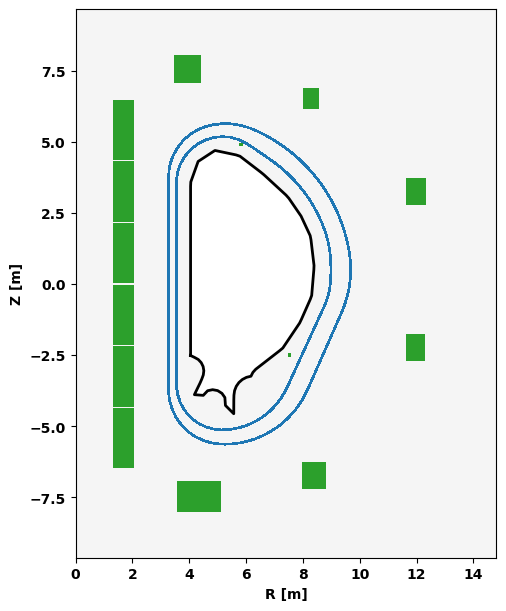

In [6]:
fig, ax = plt.subplots(1,1,constrained_layout=True)
mygs.plot_machine(fig,ax,coil_color='tab:green',cond_color='tab:blue')
ax.set_ylabel('Z [m]')
_ = ax.set_xlabel('R [m]')

### Define hard limits on coil currents
Hard limits on coil currents can be set using [set_coil_bounds](https://hansec.github.io/OpenFUSIONToolkit/docs/v1.0.0-beta4/classOpenFUSIONToolkit_1_1TokaMaker_1_1__core_1_1TokaMaker.html#a733c9b2d014ad79e3a81fc5fd11f3418). In this case we just the simple and approximate bi-directional limit of 50 MA-turns in each coil by creating an [ncoils+1,2] array with suitable values.

In [7]:
coil_bounds = np.zeros((mygs.ncoils+1,2), dtype=np.float64)
coil_bounds[:,0] = -50.E6; coil_bounds[:,1] = 50.E6

# Pass coil bounds to TokaMaker
mygs.set_coil_bounds(coil_bounds)

### Define coil regularization matrix
In general, for a given coil set a given plasma shape cannot be exactly reproduced, which generally yields large amplitude coil currents if no constraint on the coil currents is applied. As a result, it is useful to include regularization terms for the coils to balance minimization of the shape error with the amplitude of current in the free coils. In TokaMaker these regularization terms have the general form of a vector of targets (often zero), a regularization matrix that maps the coil currents to the targets, and a vector of weights that can be used to control the relative impact of each term in the minimization.

Here we use the identity as the regularization matrix, with zero for all targets and modest weights on all coils. This regularization acts to penalize the amplitude of current in each coil, acting to balance coil current with error in the shape targets.

In [8]:
coil_reg_mat = np.eye(mygs.ncoils+1, dtype=np.float64)
coil_reg_weights = 1.E-2*np.ones((mygs.ncoils+1,))
coil_reg_targets = np.zeros((mygs.ncoils+1,))

# Set weight on VSC high
coil_reg_weights[mygs.coil_sets['VS']['id']] = 1.E2

# Pass regularization terms to TokaMaker
mygs.set_coil_reg(coil_reg_mat, reg_weights=coil_reg_weights, reg_targets=coil_reg_targets)

## Compute Inverse Equilibrium

### Define shape targets
In free-boundary coil currents must be adjusted to achieve a desired plasma shape. In TokaMaker this is done by adding constraints on the poloidal flux that act to enforce the shape of the plasma. In TokaMaker we generalize utilize two types of constraints:
 1. `isoflux` points, which are points we want to lie on the same flux surface (eg. the LCFS)
 2. `saddle` points, where we want the poloidal magnetic field to vanish (eg. X-points)

**Note:** These constraints can be considered "soft" constraints, where the calculation attempts to minimize error in satisfying these constraints subject to other constraints and regularization.

Here we define a handful of isoflux points that we want to lie on the LCFS of the target equilibrium using the same boundary shape as in [example 1]().

In [9]:
nTargets = 20
R0_target = 6.3
Z0_target = 0.5
r_minor_target = 2.0
kappa_target = 1.0
delta_target = 0.0
LCFS_contour = create_isoflux(nTargets,R0_target,Z0_target,r_minor_target,kappa_target,delta_target)

# Set isoflux constraint points
mygs.set_isoflux(LCFS_contour)

### Define flux functions
Here we define flux functions for $P'$ and $F*F'$ for use in the G-S solve. In this case we will use L-mode-like profiles of the form $((1-\hat{\psi})^{\alpha})^{\gamma}$, where $\alpha$ and $\gamma$ are set differently for $P'$ and $F*F'$ to provide broad ($\alpha=1.5, \gamma=2.0$) and peaked ($\alpha=4.0, \gamma=1.0$) profiles respectively.

After building the profiles they can be plotted using the `'x'` and `'y'` dictionary fields.

Finally, the profiles are set in TokaMaker using the `set_profiles()` method.

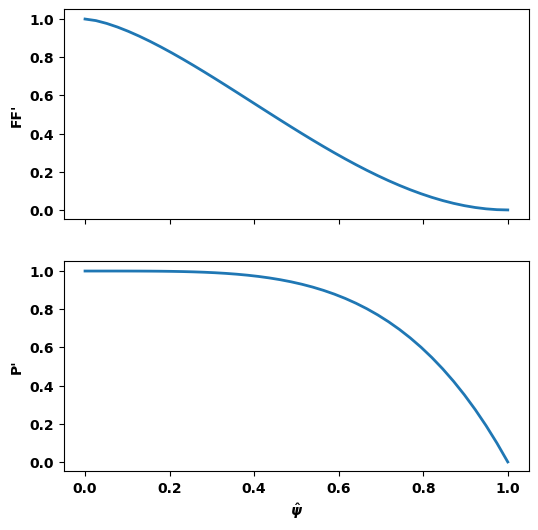

In [10]:
ffp_prof = create_power_flux_fun(40,1.5,2.0)
pp_prof = create_power_flux_fun(40,4.0,1.0)

fig, ax = plt.subplots(2,1,sharex=True)
# Plot F*F'
ax[0].plot(ffp_prof['x'],ffp_prof['y'])
ax[0].set_ylabel("FF'")
# Plot P'
ax[1].plot(pp_prof['x'],pp_prof['y'])
ax[1].set_ylabel("P'")
_ = ax[-1].set_xlabel(r"$\hat{\psi}$")

mygs.set_profiles(ffp_prof=ffp_prof,pp_prof=pp_prof)

### Define global quantities and targets
For the Grad-Shafranov solve we also define targets for the plasma current ($I_P$) and the ratio of the contributions of $P'$ and $F*F'$ to the total plasma current (`Ip_ratio`), which is related to $\beta_p$ as Ip_ratio = $1/\beta_p - 1$. This is done through a call to [set_targets](https://hansec.github.io/OpenFUSIONToolkit/docs/v1.0.0-beta4/classOpenFUSIONToolkit_1_1TokaMaker_1_1__core_1_1TokaMaker.html#ac9798f691c087d62259ceda8ebe6b0ab). During solution the scale of the $P'$ and $F*F'$ profiles will be adjusted to match these targets.

In [11]:
Ip_target=15.6E6
ratio_target=5.0
mygs.set_targets(Ip=Ip_target, Ip_ratio=ratio_target)

### Initialize $\psi$
We can now compute a free-boundary equilibrium using these constraints. Note that before running a calculation for the first time we must initialize the flux function $\psi$, which can be done using [init_psi](https://hansec.github.io/OpenFUSIONToolkit/docs/v1.0.0-beta4/classOpenFUSIONToolkit_1_1TokaMaker_1_1__core_1_1TokaMaker.html#ae532f03c0978180dbd5677e1432a9f7f). This subroutine initializes the flux using the specified Ip_target from above, which is evenly distributed over a boundary defined using a center point (R,Z), minor radius (a), and elongation ($\kappa$) and triangularity ($\delta$). Coil currents are also initialized at this point using the constraints above and this uniform plasma current.

In [12]:
err_flag = mygs.init_psi(R0_target,Z0_target,r_minor_target,kappa_target,delta_target)

### Compute Grad-Shafranov equilibrium
Now we can compute the full equilibrium using [solve](https://hansec.github.io/OpenFUSIONToolkit/docs/v1.0.0-beta4/classOpenFUSIONToolkit_1_1TokaMaker_1_1__core_1_1TokaMaker.html#acae14bbdb859253db974e30b7c92be02).

The output should show convergence of the residual (fourth column) as the nonlinear Grad-Shafranov equation is solved.

In [13]:
err_flag = mygs.solve()

Starting non-linear GS solver
     1  3.4052E+01  4.7312E-02  3.5243E-01  6.4729E+00  5.0002E-01 -2.7569E-11
     2  3.9162E+01  5.0459E-02  8.0523E-02  6.4639E+00  5.0011E-01 -2.1699E-11
     3  4.0823E+01  5.1393E-02  1.9093E-02  6.4613E+00  5.0010E-01 -6.6540E-11
     4  4.1489E+01  5.1746E-02  5.3271E-03  6.4607E+00  5.0010E-01  4.3739E-11
     5  4.1768E+01  5.1886E-02  1.8210E-03  6.4606E+00  5.0010E-01  8.7863E-11
     6  4.1885E+01  5.1942E-02  7.1511E-04  6.4607E+00  5.0010E-01  3.2627E-11
     7  4.1935E+01  5.1964E-02  3.0101E-04  6.4608E+00  5.0010E-01 -6.0339E-12
     8  4.1956E+01  5.1974E-02  1.3216E-04  6.4609E+00  5.0010E-01  2.7093E-11
     9  4.1965E+01  5.1977E-02  6.0237E-05  6.4609E+00  5.0010E-01  5.4700E-11
    10  4.1968E+01  5.1979E-02  2.8510E-05  6.4610E+00  5.0010E-01 -6.0409E-12
    11  4.1970E+01  5.1979E-02  1.3988E-05  6.4610E+00  5.0010E-01  5.0022E-12
    12  4.1971E+01  5.1979E-02  7.0741E-06  6.4610E+00  5.0010E-01 -5.0216E-11
    13  4.1971E+01  5.

### Print information and plot equilibrium
After computing the equilibrium, basic parameters can be displayed using the [print_info](https://hansec.github.io/OpenFUSIONToolkit/docs/v1.0.0-beta4/classOpenFUSIONToolkit_1_1TokaMaker_1_1__core_1_1TokaMaker.html#a46c8bde43e120175614bb373c18a970c) method. For access to these quantities as variables instead the [get_stats](https://hansec.github.io/OpenFUSIONToolkit/docs/v1.0.0-beta4/classOpenFUSIONToolkit_1_1TokaMaker_1_1__core_1_1TokaMaker.html#a30af13a91045f3a12a6a1f59239cce2b) can be used.

In [14]:
mygs.print_info()

Equilibrium Statistics:
  Topology                =   Limited
  Toroidal Current [A]    =    1.5600E+07
  Current Centroid [m]    =    6.331  0.500
  Magnetic Axis [m]       =    6.461  0.500
  Elongation              =    0.998 (U:  0.998, L:  0.998)
  Triangularity           =    0.003 (U:  0.006, L: -0.000)
  Plasma Volume [m^3]     =   545.390
  q_0, q_95               =    0.500  1.227
  Peak Pressure [Pa]      =    5.6359E+05
  Stored Energy [J]       =    1.5459E+08
  <Beta_pol> [%]          =   20.9314
  <Beta_tor> [%]          =    1.7627
  Diamagnetic flux [Wb]   =    2.1858E+00
  Toroidal flux [Wb]      =    7.6812E+01
  l_i                     =    1.1042


As above we can plot the machine geometry, including current in each coil set, using the [plot_machine](https://hansec.github.io/OpenFUSIONToolkit/docs/v1.0.0-beta4/classOpenFUSIONToolkit_1_1TokaMaker_1_1__core_1_1TokaMaker.html#a81aa74a32baf549b801da814117642bb) subroutine. Then flux surfaces can be added to the plot using [plot_psi](https://hansec.github.io/OpenFUSIONToolkit/docs/v1.0.0-beta4/classOpenFUSIONToolkit_1_1TokaMaker_1_1__core_1_1TokaMaker.html#a61550b8069c6e27d978fac742b620089). Constraints can also be added using the [plot_constraints](https://hansec.github.io/OpenFUSIONToolkit/docs/v1.0.0-beta4/classOpenFUSIONToolkit_1_1TokaMaker_1_1__core_1_1TokaMaker.html#a44cfe034255bb6439b2b1f9304c77b52) subroutine.

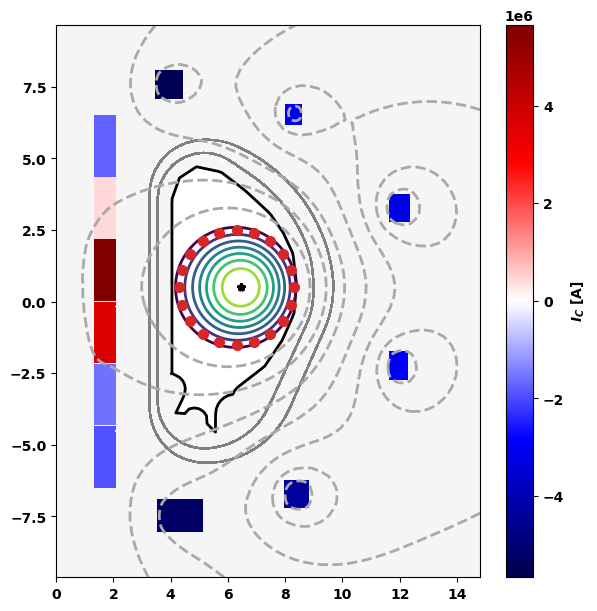

In [15]:
fig, ax = plt.subplots(1,1,constrained_layout=True)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True)
mygs.plot_psi(fig,ax)
mygs.plot_constraints(fig,ax,isoflux_marker='o')

# Scan shape parameters

Before performing a scan we can turn off the progress printing from above by adjusting the `pm` setting to False and calling `update_settings()`.

In [16]:
mygs.settings.pm=False
mygs.update_settings()

Here we define a simple helper function to produce formatted plots of the equilibrium and coil currents.

In [17]:
def formatted_plot(gs_obj,title):
    fig, ax = plt.subplots(1,1,constrained_layout=True)
    ax.set_title(title)
    gs_obj.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]')
    gs_obj.plot_psi(fig,ax,xpoint_color=None,vacuum_nlevels=4)
    gs_obj.plot_constraints(fig,ax,isoflux_color='tab:red',isoflux_marker='o')
    ax.set_ylabel('Z [m]')
    ax.set_xlabel('R [m]')

def formatted_coil_plot(gs_obj):
    coil_names = ['' for _ in range(mygs.ncoils)]
    for key, value in mygs.coil_sets.items():
        coil_names[value['id']] = key
    #
    curr_fig, curr_ax = plt.subplots(1,1,figsize=(8,4),constrained_layout=True)
    curr_ax.grid(True)
    curr_ax.set_ylabel('Coil current [MA-turn]')
    curr_ax.set_xlabel('Coil set')
    curr_ax.set_xlim(0,mygs.ncoils-1)
    curr_ax.set_xticks(range(mygs.ncoils))
    curr_ax.set_xticklabels(coil_names)
    return curr_ax

## Scan elongation ($\kappa$)

Now we will perform a scan of elongation ($\kappa$) by adjusting the isoflux targets. At each value we re-solve the G-S equation and plot the evolution of the coil currents (from `get_coil_currents()`) and plasma equilibrium.

As the elongation increases currents in the upper/lower coils need to change to pull the plasma up, while the outer coil currents must increase to maintain force balance.

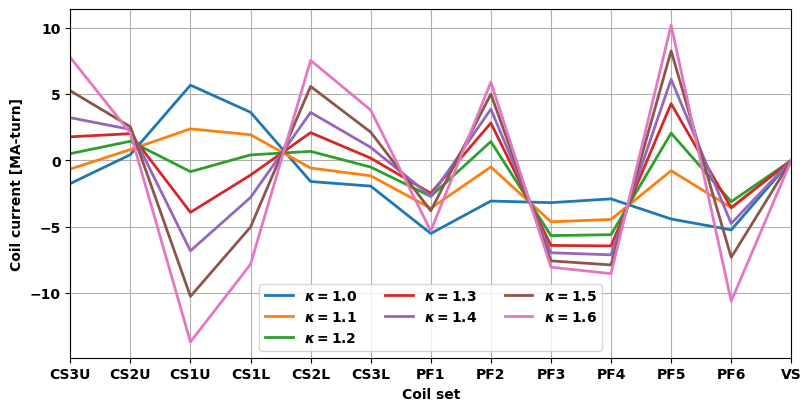

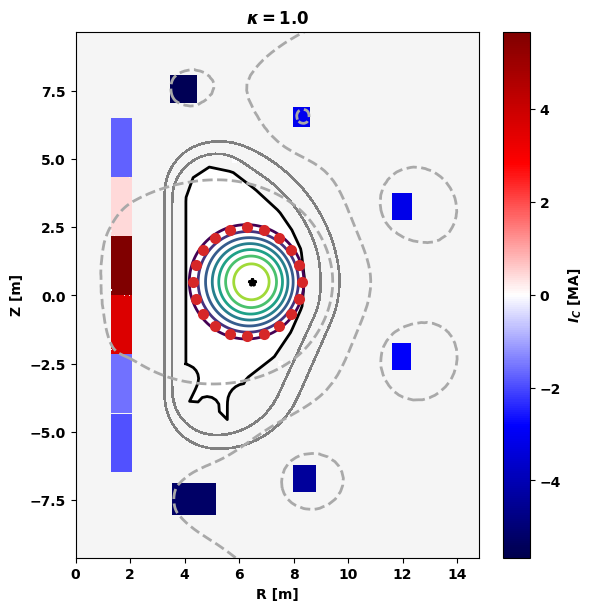

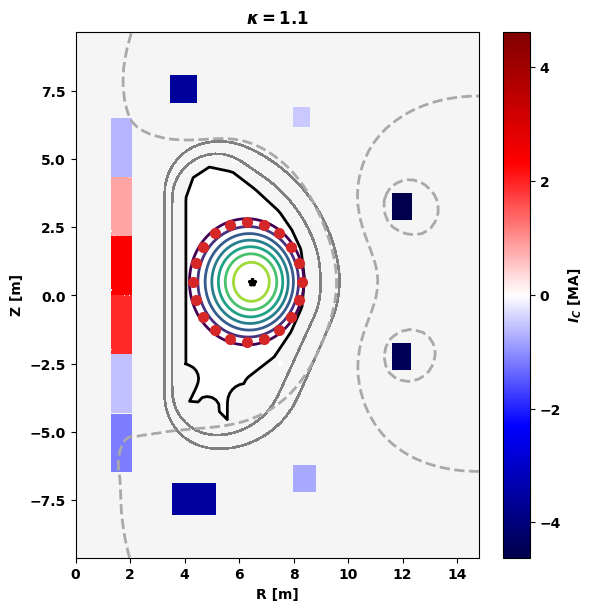

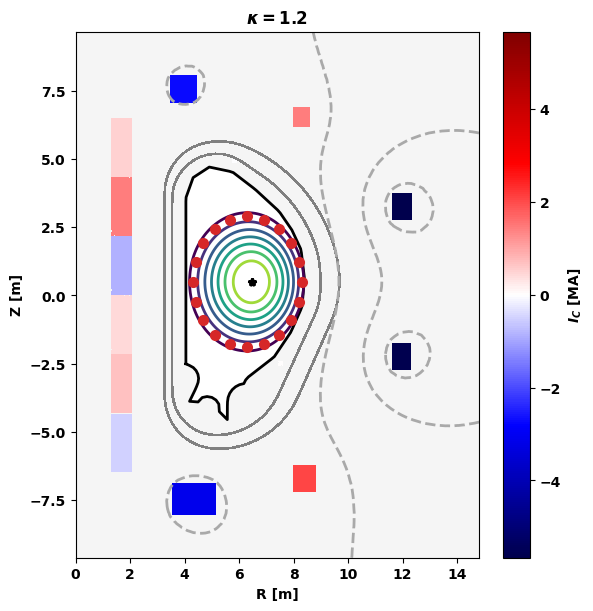

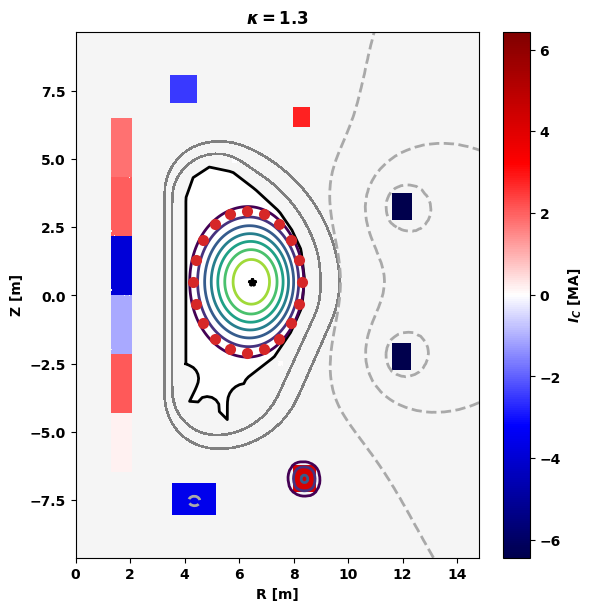

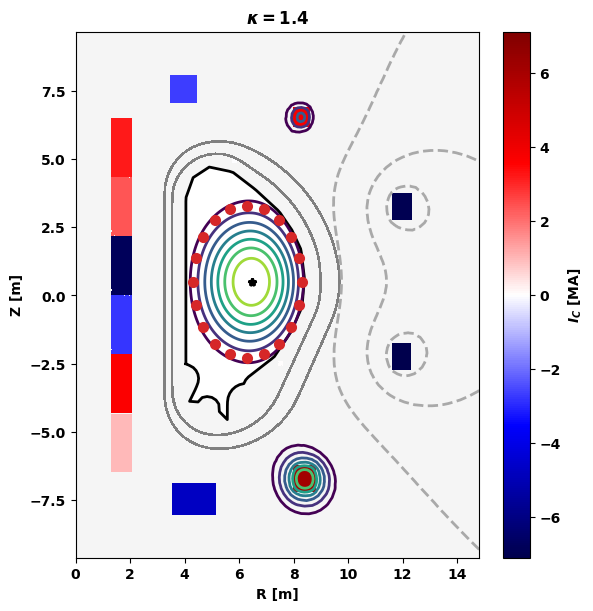

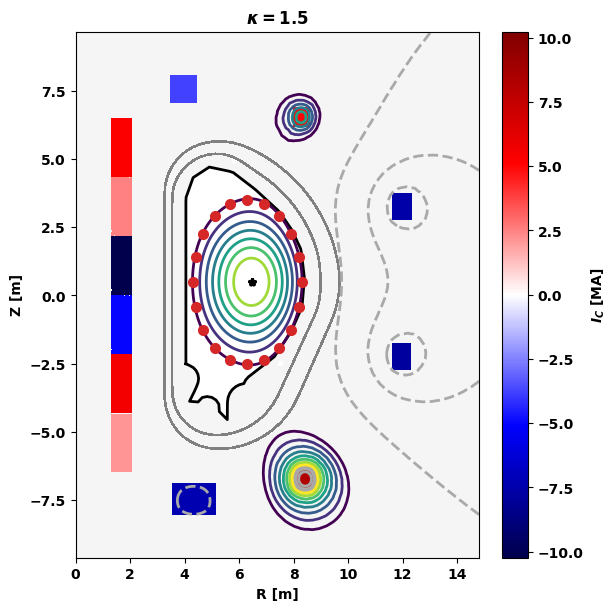

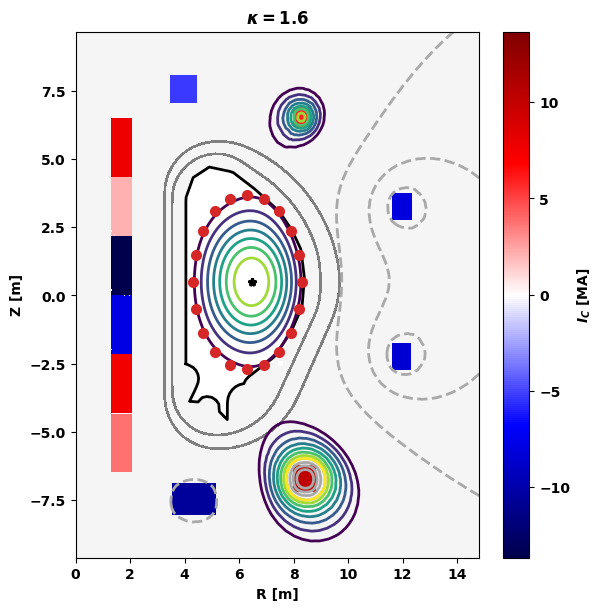

In [18]:
curr_ax = formatted_coil_plot(mygs)
for kappa_target_tmp in np.linspace(1.0,1.6,7):
    
    # Set new target for kappa
    LCFS_contour = create_isoflux(nTargets,R0_target,Z0_target,r_minor_target,kappa_target_tmp,delta_target)
    mygs.set_isoflux(LCFS_contour)
    
    # Re-solve
    err_flag = mygs.solve()
    
    # Plot coil currents
    currents, _ = mygs.get_coil_currents()
    curr_ax.plot(currents/1.E6,label=r'$\kappa = {0:.1f}$'.format(kappa_target_tmp))
    
    # Plot
    formatted_plot(mygs,r'$\kappa = {0:.1f}$'.format(kappa_target_tmp))

# Draw legend
_ = curr_ax.legend(ncols=3)

## Scan triangularity ($\delta$)
Now we will perform a scan of triangularity ($\delta$) while maintaining $\kappa=1.6$ by adjusting the isoflux targets. At each value we re-solve the G-S equation and plot the evolution of the coil currents (from `get_coil_currents()`) and plasma equilibrium.

As the triangularity increases the maximum coil current continues to increase. Eventually an X-point is formed at the top of the device producing a diverted equilibrium. However, in ITER the divertor is located on the bottom of the device, so this would be a very bad equilibrium in ITER!!

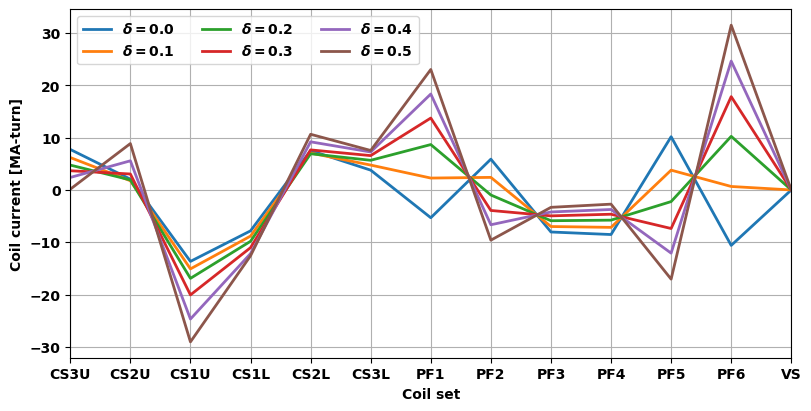

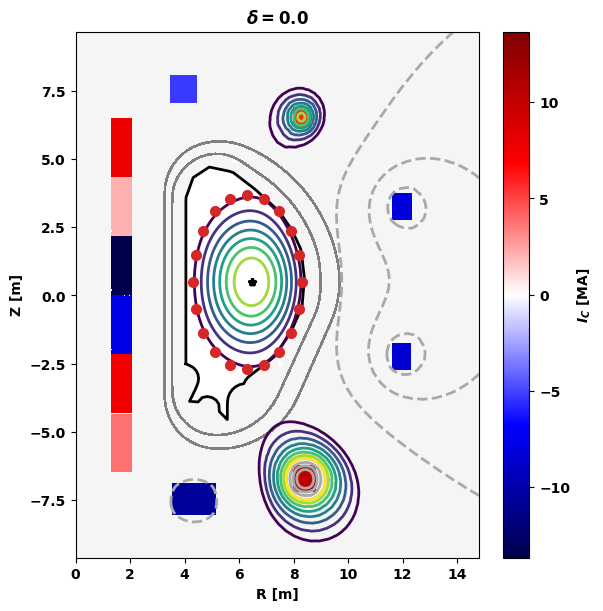

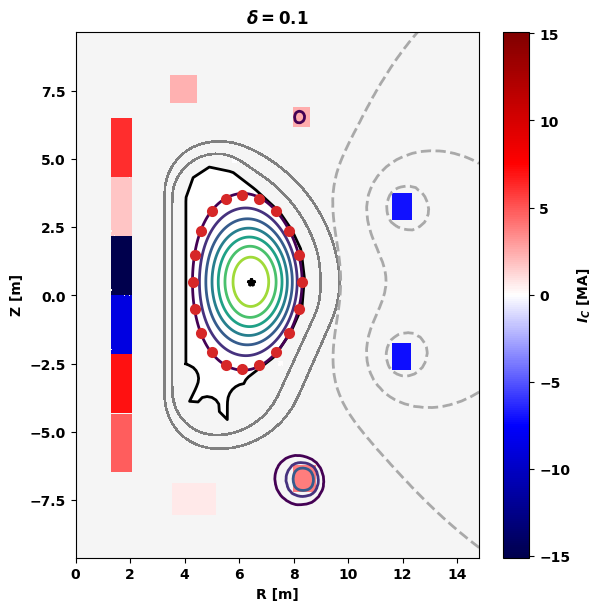

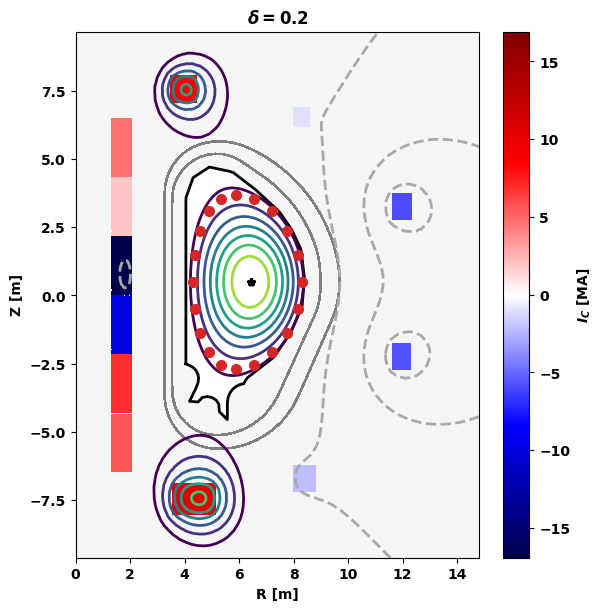

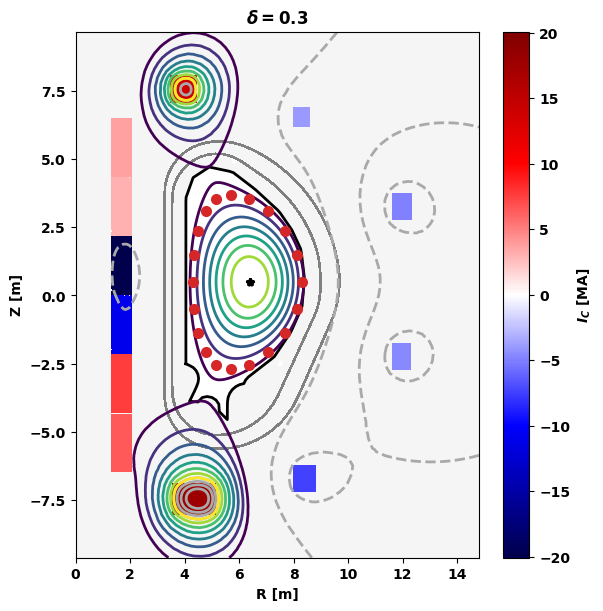

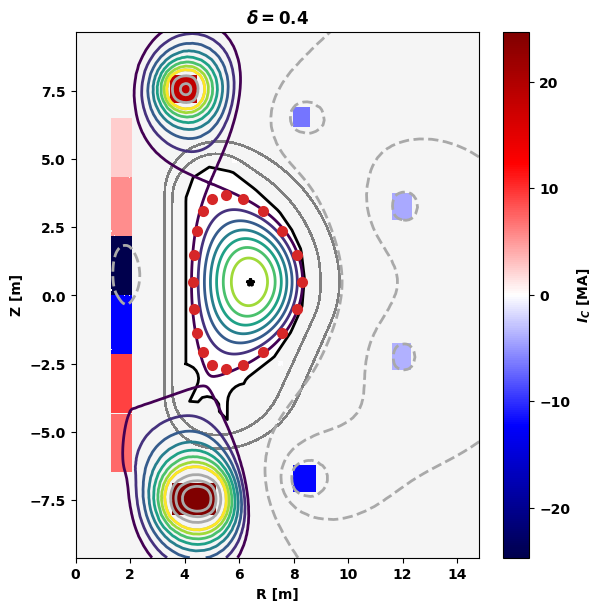

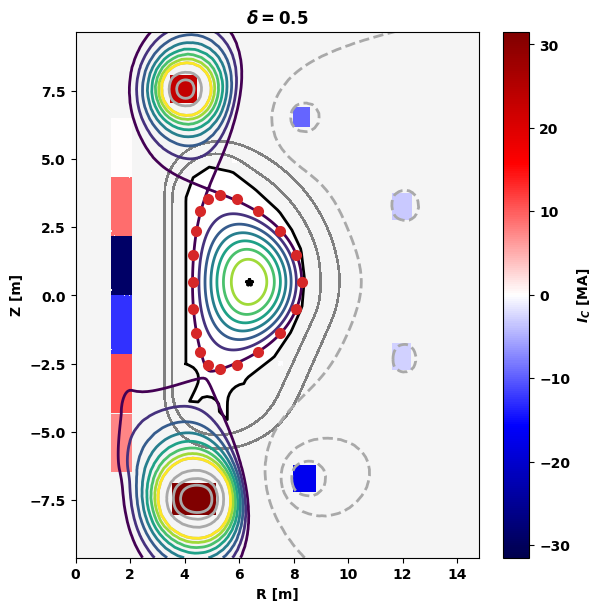

In [19]:
kappa_target = 1.6
curr_ax = formatted_coil_plot(mygs)
for delta_target_tmp in np.linspace(0.0,0.5,6):
    
    # Set new target for delta
    LCFS_contour = create_isoflux(nTargets,R0_target,Z0_target,r_minor_target,kappa_target,delta_target_tmp)
    mygs.set_isoflux(LCFS_contour)
    
    # Resolve
    err_flag = mygs.solve()
    
    # Plot coil currents
    currents, _ = mygs.get_coil_currents()
    curr_ax.plot(currents/1.E6,label=r'$\delta = {0:.1f}$'.format(delta_target_tmp))
    
    # Plot
    formatted_plot(mygs,r'$\delta = {0:.1f}$'.format(delta_target_tmp))

# Draw legend
_ = curr_ax.legend(ncols=3)

# Choose your own adventure

 * What is the highest stored energy you can get?
 * What is the higher plasma current you can get?
 * Can you get the shape you want while keeping the OH coils all one direction?
 * What does the safety factor ($q$) look like as we adjust the shape?
 * Where can you place the X-point and strike points?